In [1]:
library(tidyverse)
library(cowplot)
library(ggrepel)
library(ggExtra)
library(ggbeeswarm)

`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



## Calibration curves

In [2]:
full_cal_bins <- read_csv('hetionet_calibration_bins.csv')
sampled_cal_bins <- read_csv('hetionet_calibration_bins_sampled.csv')

Parsed with column specification:
cols(
  expected_frac = col_double(),
  lower_ci = col_double(),
  upper_ci = col_double(),
  feature = col_character(),
  feature_value = col_double(),
  metaedge = col_character()
)
Parsed with column specification:
cols(
  expected_frac = col_double(),
  lower_ci = col_double(),
  upper_ci = col_double(),
  feature = col_character(),
  feature_value = col_double(),
  metaedge = col_character()
)


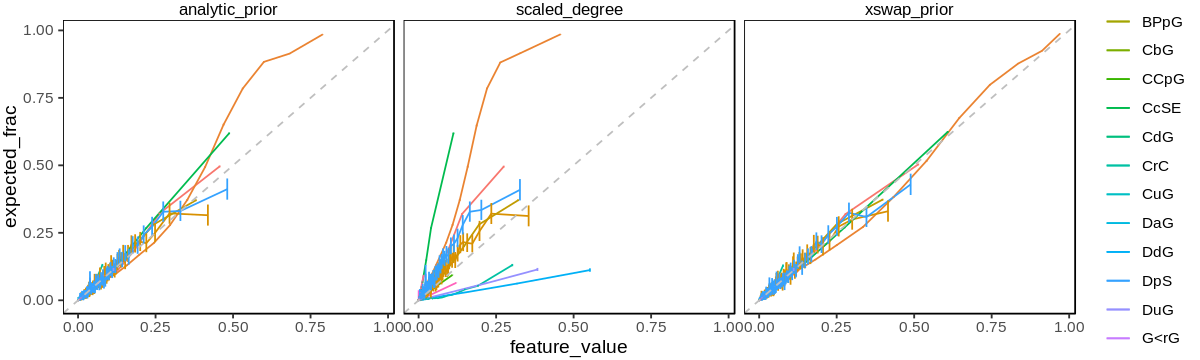

In [3]:
options(repr.plot.width=10, repr.plot.height=3)

full_calibration_plot <- (
    ggplot(full_cal_bins, aes(x = feature_value, y = expected_frac, ymin = lower_ci, 
                              ymax = upper_ci, color = metaedge))
    + geom_line()
    + geom_errorbar()
    + geom_abline(color = 'grey', linetype = 'dashed')
    + facet_wrap(vars(feature), nrow = 1)
    + theme_zietzm()
)

sampled_calibration_plot <- (
    ggplot(sampled_cal_bins, aes(x = feature_value, y = expected_frac, ymin = lower_ci, 
                              ymax = upper_ci, color = metaedge))
    + geom_line()
    + geom_errorbar()
    + geom_abline(color = 'grey', linetype = 'dashed')
    + facet_wrap(vars(feature),  nrow = 1)
    + theme_zietzm()
)
    
full_calibration_plot

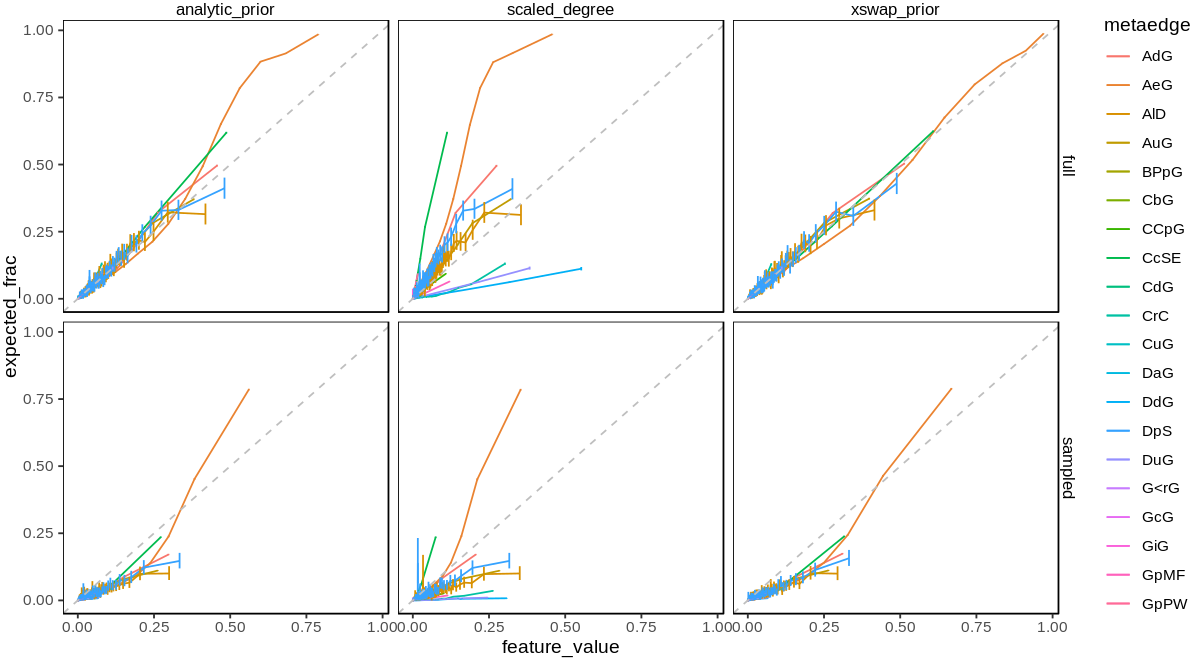

In [4]:
options(repr.plot.width=10, repr.plot.height=5.5)


calibration_plot <- bind_rows(
    full_cal_bins %>% mutate(network = 'full'),
    sampled_cal_bins %>% mutate(network = 'sampled')
) %>% 
ggplot(aes(x = feature_value, y = expected_frac, ymin = lower_ci, 
                ymax = upper_ci, color = metaedge)) + 
geom_line() + 
geom_errorbar() + 
geom_abline(color = 'grey', linetype = 'dashed') + 
facet_grid(rows = vars(network), cols = vars(feature)) +
theme_zietzm()

calibration_plot

## Calibration metrics

In [5]:
metrics <- read_csv('hetionet_calibration_metrics.csv')

metrics %>% head

Parsed with column specification:
cols(
  network = col_character(),
  metaedge = col_character(),
  feature = col_character(),
  cal = col_double(),
  ref = col_double(),
  brier = col_double(),
  auroc = col_double()
)


network,metaedge,feature,cal,ref,brier,auroc
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
full,AdG,xswap_prior,0.0005348332,0.007573513,0.008108346,0.9893918
full,AdG,analytic_prior,0.0006444262,0.007571256,0.008215682,0.9891555
full,AdG,scaled_degree,0.0015091243,0.007574097,0.009083222,0.9891437
full,AeG,xswap_prior,0.0011463458,0.018729566,0.019875912,0.9873503
full,AeG,analytic_prior,0.0045910898,0.018719604,0.023310694,0.9868655
full,AeG,scaled_degree,0.0195552381,0.018735534,0.038290772,0.9868530


In [6]:
mean_metrics <- metrics %>%
    group_by(network, feature) %>%
    summarize_at(c('cal', 'ref', 'brier', 'auroc'), mean) %>%
    gather('metric', 'value', cal, ref, brier, auroc) %>%
    ungroup() %>%
    mutate(
        network = network %>% factor(levels = c('full', 'sampled', 'other')),
        feature = feature %>% factor(levels = c('analytic_prior', 'scaled_degree', 'xswap_prior'))
    )

mean_metrics %>% filter(metric == 'cal') %>% spread(network, value)

feature,metric,full,sampled,other
<fct>,<chr>,<dbl>,<dbl>,<dbl>
analytic_prior,cal,0.0007417202,0.0022613753,0.116271170
scaled_degree,cal,0.0018726902,0.0006669263,0.008179661
xswap_prior,cal,0.0003926411,0.0003241299,0.007451385


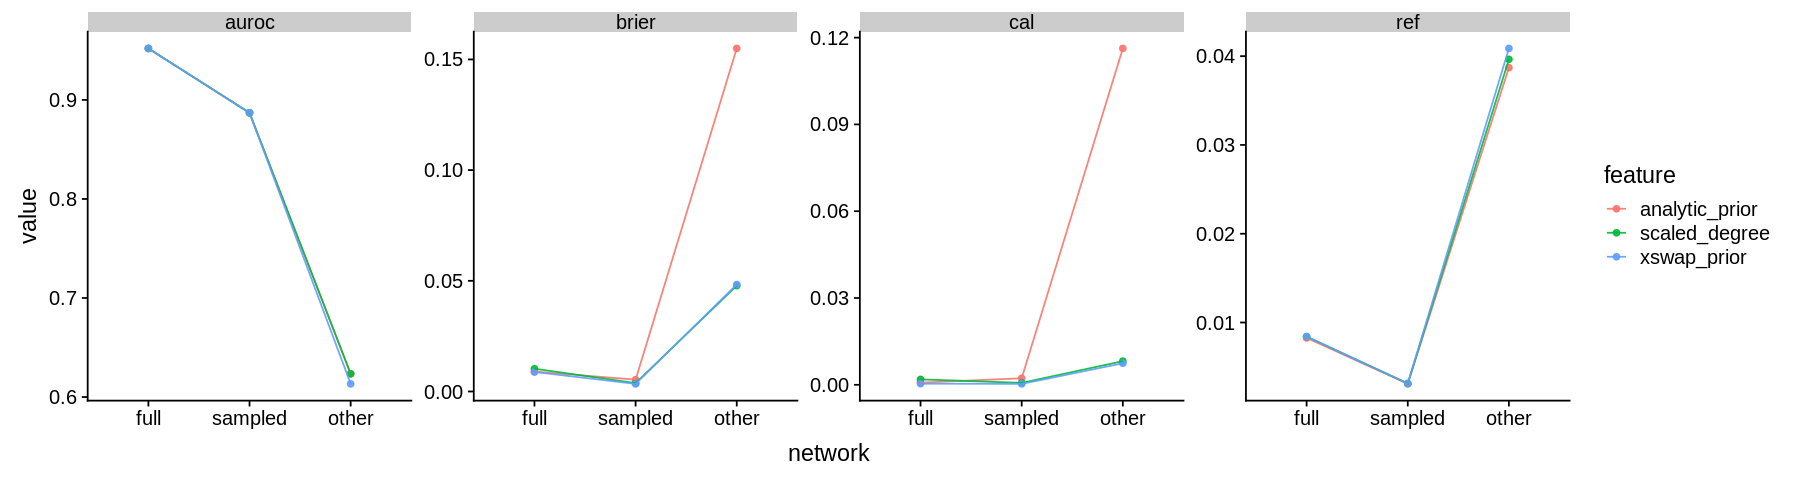

In [7]:
options(repr.plot.width=15, repr.plot.height=4)

(
    ggplot(mean_metrics, aes(x = network, y = value, group = feature, color = feature))
    + geom_point(alpha = 0.9)
    + geom_line(alpha = 0.9)
#     + geom_label_repel(data = mean_metrics %>% filter(network == 'sampled' & metric == 'ref'), 
#                        aes(label = feature), nudge_x = 1, nudge_y = 0.003)
    + facet_wrap(vars(metric), nrow = 1, scales = 'free_y')
)

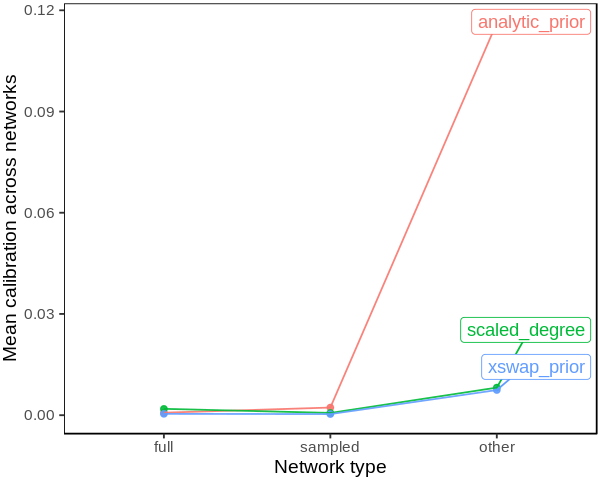

In [8]:
options(repr.plot.width=5, repr.plot.height=4)

mean_cal <- (
    ggplot(mean_metrics %>% filter(metric == 'cal'), 
           aes(x = network, y = value, group = feature, color = feature))
    + geom_point(alpha = 0.9)
    + geom_line(alpha = 0.9)
    + geom_label_repel(data = mean_metrics %>% filter(metric == 'cal' & network == 'other'),
                       aes(label = feature), nudge_x = 5, nudge_y = 0.01)
    + ylab('Mean calibration across networks')
    + xlab('Network type')
    + theme_zietzm()
    + theme(legend.position = "none")
)

mean_cal

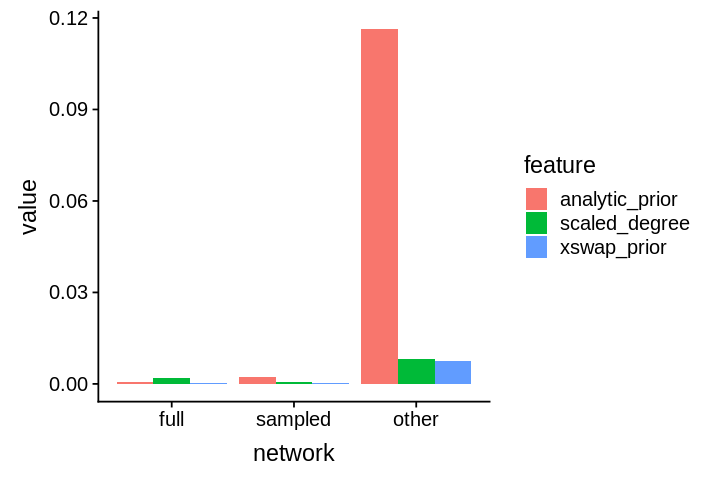

In [9]:
options(repr.plot.width=6, repr.plot.height=4)

(
    ggplot(mean_metrics %>% filter(metric == 'cal'), 
           aes(x = network, y = value, group = feature))
    + geom_col(aes(fill = feature), position = 'dodge')
)

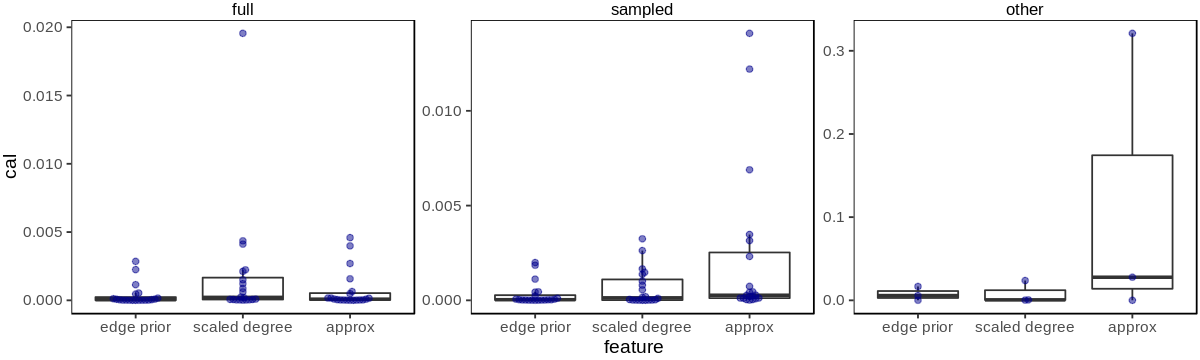

In [10]:
options(repr.plot.width=10, repr.plot.height=3)

all_cal <- (
    ggplot(metrics %>%
               mutate(
                   network = network %>% factor(levels = c('full', 'sampled', 'other')),
                   feature = feature %>% recode_factor(xswap_prior = 'edge prior', 
                                                       scaled_degree = 'scaled degree', 
                                                       analytic_prior = 'approx'),
               ), 
           aes(x = feature, y = cal))
    + facet_wrap(vars(network), scales = 'free_y')
    + geom_boxplot(outlier.shape = NA)
    + geom_beeswarm(alpha = 0.5, color = 'darkblue')
    + theme_zietzm()
)

all_cal

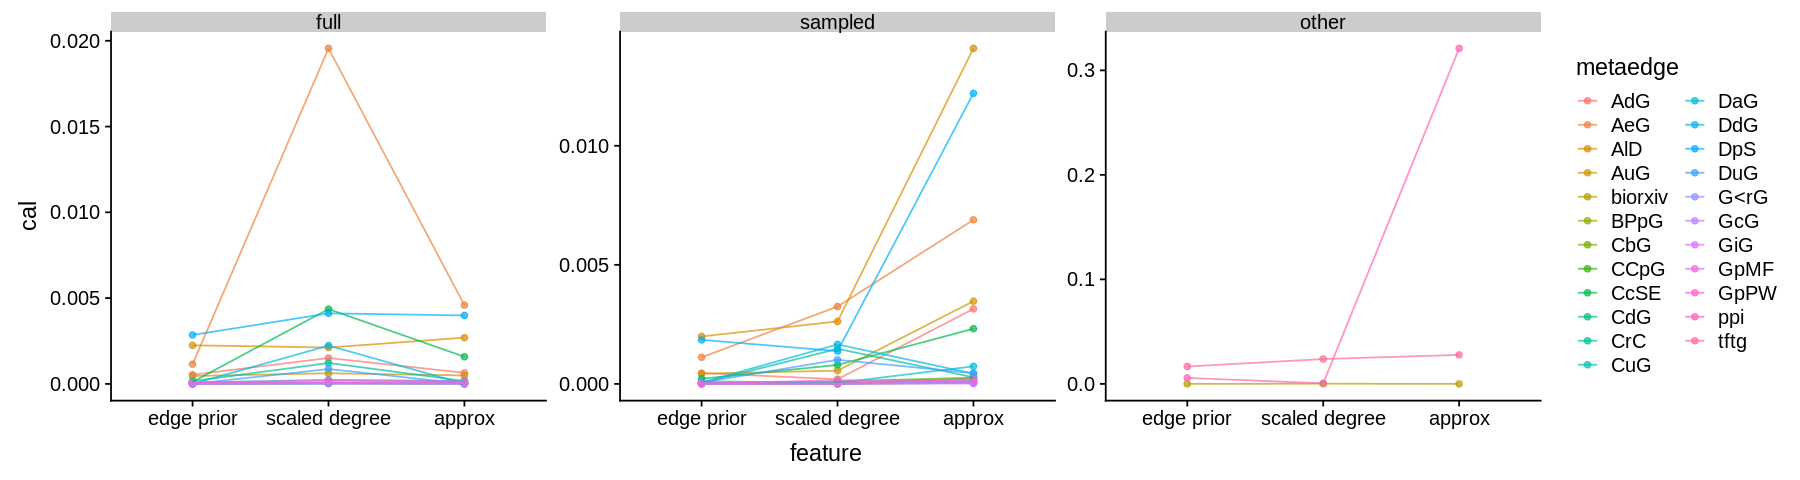

In [11]:
options(repr.plot.width=15, repr.plot.height=4)

(
    ggplot(metrics %>%
               mutate(
                   network = network %>% factor(levels = c('full', 'sampled', 'other')),
                   feature = feature %>% recode_factor(xswap_prior = 'edge prior', 
                                                       scaled_degree = 'scaled degree', 
                                                       analytic_prior = 'approx'),
               ), 
           aes(x = feature, y = cal, group = metaedge, color = metaedge))
    + facet_wrap(vars(network), scales = 'free_y')
#     + geom_boxplot(outlier.shape = NA)
#     + geom_beeswarm(alpha = 0.5, color = 'darkblue')
    + geom_point(alpha = 0.7)
    + geom_line(alpha = 0.7)
)

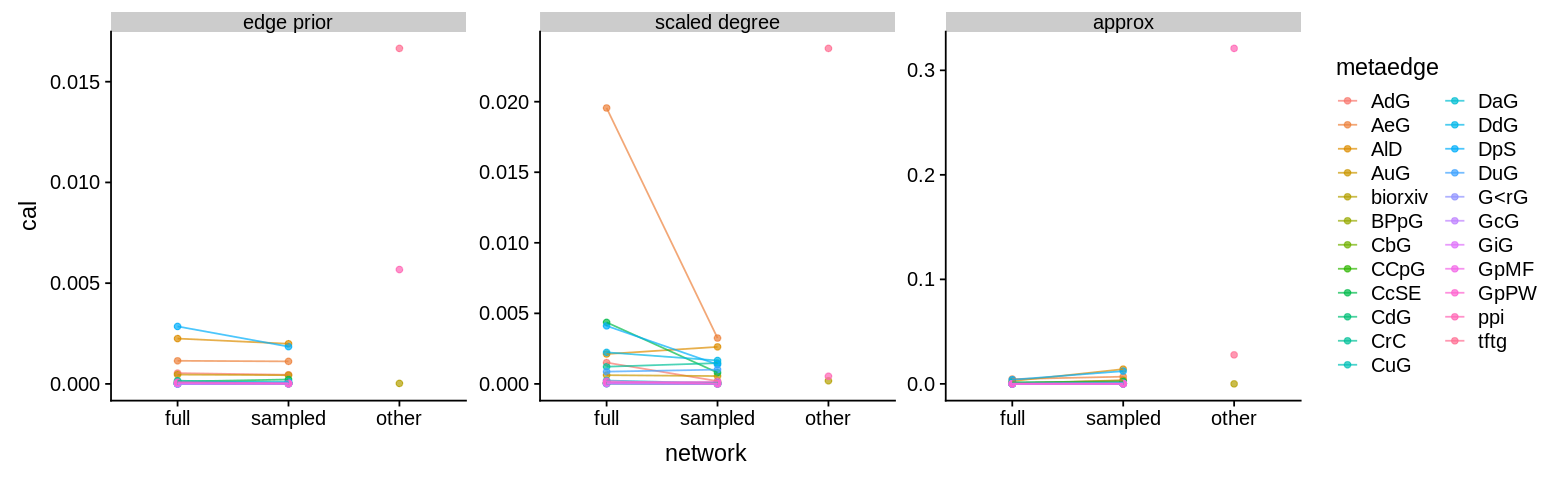

In [12]:
options(repr.plot.width=13, repr.plot.height=4)

(
    ggplot(metrics %>%
               mutate(
                   network = network %>% factor(levels = c('full', 'sampled', 'other')),
                   feature = feature %>% recode_factor(xswap_prior = 'edge prior', 
                                                       scaled_degree = 'scaled degree', 
                                                       analytic_prior = 'approx'),
               ), 
           aes(x = network, y = cal, group = metaedge, color = metaedge))
    + facet_wrap(vars(feature), scales = 'free_y')
#     + geom_boxplot(outlier.shape = NA)
#     + geom_beeswarm(alpha = 0.5, color = 'darkblue')
    + geom_point(alpha = 0.7)
    + geom_line(alpha = 0.7)
)

In [ ]:
# options(repr.plot.width=12, repr.plot.height=10)

# second_row <- plot_grid(mean_cal, all_cal, labels = c("C", "D"), nrow = 1, rel_widths = c(0.5, 1.5))

# calibration_figure <- plot_grid(full_calibration_plot + theme(legend.position = "none"), 
#           sampled_calibration_plot + theme(legend.position = "none"), 
#           second_row, ncol = 1, labels = c("A", "B", ""))

# ggsave(filename = '../../img/calibration_combined.png', plot = calibration_figure, 
#        dpi = 300, width = 12, height = 10)
# calibration_figure

options(repr.plot.width=9, repr.plot.height=8)

calibration_figure <- plot_grid(full_calibration_plot + theme(legend.position = "none"), 
          sampled_calibration_plot + theme(legend.position = "none"), 
          all_cal, ncol = 1, labels = c("A", "B", "C"))

ggsave(filename = '../../img/calibration_combined.png', plot = calibration_figure, 
       dpi = 300, width = 9, height = 8)
calibration_figure

In [ ]:
network_size <- read_csv('original_work/hetionet_features.csv')

In [ ]:
metrics %>%
filter(network == 'full' & feature == 'xswap_prior') %>%
left_join(network_size, by = 'metaedge') %>%
select(metaedge, feature, cal, auroc, density, gini, num_source, num_target) %>%
arrange(auroc)

In [ ]:
metrics %>%
filter(network == 'sampled' & feature == 'xswap_prior') %>%
left_join(network_size, by = 'metaedge') %>%
select(metaedge, feature, cal, auroc, density, gini, num_source, num_target) %>%
arrange(auroc)

In [ ]:
options(repr.plot.width=8, repr.plot.height=4)

metrics %>%
filter(feature == 'xswap_prior' & network != 'other') %>%
left_join(network_size, by = 'metaedge') %>%
ggplot(aes(x = gini, y = auroc)) +
geom_smooth(method = 'lm') +
geom_point() +
facet_wrap(vars(network))

In [ ]:
options(repr.plot.width=6, repr.plot.height=5)

metrics %>%
filter(feature == 'xswap_prior', network != 'other') %>%
mutate(network = network %>% factor(levels = c('full', 'sampled'))) %>%
ggplot(aes(x = network, y = auroc, group = metaedge)) +
geom_point() +
geom_line()

In [ ]:
metrics %>%
filter(feature == 'xswap_prior', network != 'other') %>%
select(metaedge, network, feature, auroc) %>%
mutate(network = network %>% recode_factor(full = "unsampled", sampled = "sampled")) %>%
spread(network, auroc) %>%
arrange(desc(unsampled))

In [ ]:
options(repr.plot.width=5, repr.plot.height=4)

auroc_plot <- metrics %>%
filter(feature == 'xswap_prior', network != 'other') %>%
select(metaedge, network, feature, auroc) %>%
mutate(network = network %>% recode_factor(full = "unsampled", sampled = "sampled")) %>%
spread(network, auroc) %>%
ggplot(aes(x = unsampled, y = sampled)) +
geom_abline(color = 'grey', linetype = 'dashed') +
geom_point() +
xlim(0.5, 1) +
ylim(0.5, 1) +
theme_zietzm()

auroc_plot <- ggMarginal(auroc_plot, type = 'histogram', size = 5)
ggsave(filename = '../../img/full_vs_sampled_auroc.png', plot = auroc_plot, dpi = 300, width = 5, height = 4)
auroc_plot

## Feature correlation

In [ ]:
corr_df <- read_tsv('hetionet_feature_correlation.tsv')
corr_df %>% head

In [ ]:
# Summarize how correlated features are
corr_df %>%
    gather('pair', 'correlation', xswap_analytic, xswap_degree) %>%
    summarize_at(.vars = 'correlation', .funs = c('min' = min, 'median' = median, 'max' = max))

In [ ]:
# Summarize how similar the features AUROC values are
metrics %>%
    select(network, metaedge, feature, auroc) %>%
    spread(feature, auroc) %>%
    mutate(max_diff = max(abs(c(analytic_prior - scaled_degree, 
                                analytic_prior - xswap_prior, 
                                scaled_degree - xswap_prior)))) %>%
    summarize(max(max_diff))

In [ ]:
# Are the features any less correlated in the sampled network?
corr_df %>%
    gather('pair', 'correlation', starts_with('xswap')) %>%
#     spread('network', 'correlation') %>%
    ggplot(aes(x = network, y = correlation, group = metaedge)) + 
    geom_point() +
    geom_line() +
    facet_wrap(vars(pair))

In [ ]:
options(repr.plot.width=5, repr.plot.height=3)

auroc_tasks <- metrics %>%
filter(feature == 'xswap_prior') %>%
# mutate(network = network %>% factor(levels = c('full', 'sampled', 'other'))) %>%
mutate(network = network %>% recode_factor(full = "unsampled", sampled = 'sampled', other = 'separate')) %>%
ggplot(aes(x = network, y = auroc)) + 
# geom_boxplot(outlier.shape = NA) +
geom_violin() +
geom_beeswarm(alpha = 0.5, color = 'darkblue', cex = 1.7) +
theme_zietzm() +
ylab('Edge prior AUROC') +
xlab('Network type') +
coord_cartesian(ylim = c(0.5, 1.1)) +
scale_y_continuous(breaks = c(0.5, 0.6, 0.7, 0.8, 0.9, 1.0)) +
geom_label(data = data.frame(network = c('unsampled', 'sampled', 'separate'), 
                             label = c('Task 1', 'Task 2', 'Task 3'),
                             auroc = rep(x = 1.08, times = 3)),
          aes(label = label))

ggsave(filename = '../../img/auroc_by_task.png', auroc_tasks, dpi = 300, width = 5, height = 3)
auroc_tasks

In [ ]:
options(repr.plot.width=8, repr.plot.height=3)

combined_auroc_plot <- plot_grid(auroc_tasks, auroc_plot, labels = c("A", "B"))

ggsave(filename = '../../img/combined_auroc.png', combined_auroc_plot, dpi = 300, width = 8, height = 3)
combined_auroc_plot